In [1]:
import sys
sys.path.append('/Users/jiangwengyao/Desktop/eeg-artifact-removal-master/')
#sys.path.append('/Users/jiangwengyao/Desktop/eeg-artifact-removal-master/definitions.py')

In [2]:
!pip install EntropyHub

In [3]:
!pip install mne

In [4]:
import definitions
import importlib
import datasetio.read as read
from ArtifactRemoval.utils import decompose
import numpy as np
import PyEMD
import matplotlib.pyplot as plt
import mne
import math

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
RECORD_INDEX = 1

# Read Data

In [6]:
importlib.reload(definitions)
importlib.reload(read)
print(definitions.CONTAMINATED_EEG)#显示路径

con_eeg = read.readRecord(RECORD_INDEX)#参数为True的情况可能表示读取的数据为包含杂散EEG数据
pure_eeg = read.readRecord(RECORD_INDEX, False)#反之

/Users/jiangwengyao/Desktop/A semi-simulated EEGEOG dataset for the comparison of EOG artifact rejection techniques/Contaminated_Data.mat


In [7]:
print(con_eeg)

print(con_eeg.shape)
print(pure_eeg.shape)

[[ 11.31871986  12.29839897  10.28273773 ...  66.90544128  68.03845215
   64.36378479]
 [-13.92522812 -25.65973663 -25.86351585 ...  56.94568634  57.00891495
   58.0173912 ]
 [ 10.39846134  11.56166363   9.39088535 ...  39.89983749  40.64390945
   32.52783966]
 ...
 [  5.26071739   4.60958052   3.34262848 ...  33.87456894  33.86003113
   28.50689697]
 [  6.43552828   6.95472622   6.02824688 ...  13.1681881   13.53517151
   11.73553753]
 [  9.35468769   5.78854561  -0.81906354 ...  20.86396217  20.28285599
   13.17710686]]
(19, 5601)
(19, 5601)


In [8]:
print(con_eeg[0:3])

[[ 11.31871986  12.29839897  10.28273773 ...  66.90544128  68.03845215
   64.36378479]
 [-13.92522812 -25.65973663 -25.86351585 ...  56.94568634  57.00891495
   58.0173912 ]
 [ 10.39846134  11.56166363   9.39088535 ...  39.89983749  40.64390945
   32.52783966]]


In [9]:
#return entropy, kurt
decompose.ica_component_sqa(pure_eeg[1])

(0.8637844440877565, -0.1609734006278667)

In [10]:
#return entropy, kurt
decompose.ica_component_sqa(con_eeg[1])

(1.4256992927476917, 1.242400124034556)

# IMF Decompose

In [11]:
#用于重新加载一个已经导入的模块。
#only choose three channels 
importlib.reload(decompose)
imfs, imf_ch_names, residuals = decompose.get_imfs(con_eeg[0:3], ['1', '2', '3'])#def get_imfs(data, ch_names)

'artifact_removal, channel_number: 3 data_length: 5601'


In [12]:
print(imfs.shape)#after decomposing
print(con_eeg[0:3])

(36, 5601)
[[ 11.31871986  12.29839897  10.28273773 ...  66.90544128  68.03845215
   64.36378479]
 [-13.92522812 -25.65973663 -25.86351585 ...  56.94568634  57.00891495
   58.0173912 ]
 [ 10.39846134  11.56166363   9.39088535 ...  39.89983749  40.64390945
   32.52783966]]


In [13]:
importlib.reload(decompose)
good_imf_indexes, bad_imf_indexes = decompose.imf_filtering(imfs, imf_ch_names, entropy_threshold=.5, kurt_threshold=.5)

entropy_threshold 0.5 kurt_threshold 0.5
    ch_name   entropy      kurt
0   3 imf12  0.993932 -1.383419
1   3 imf11  0.459538 -1.203229
2   3 imf10 -0.064589  0.314944
3    3 imf9  0.766299  0.431573
4    3 imf8  0.843366  0.087569
5    3 imf7  0.908348 -0.280981
6    3 imf6  0.655168  1.116315
7    3 imf5  0.455636  1.060766
8    3 imf4 -0.337547  0.368336
9    3 imf3 -0.841746  0.095390
10   3 imf2 -1.679190 -0.031119
11   3 imf1 -2.050104  0.049766
12  2 imf12  0.866145 -1.452713
13  2 imf11  0.288288 -1.409596
14  2 imf10  0.587754 -1.244055
15   2 imf9  0.917123 -0.042867
16   2 imf8  0.763907 -0.122961
17   2 imf7  0.920583 -0.049150
18   2 imf6  0.439400  1.506500
19   2 imf5  0.216536  2.735667
20   2 imf4 -0.406280 -0.563460
21   2 imf3 -0.870538  0.223698
22   2 imf2 -1.737361  0.354386
23   2 imf1 -2.065212 -0.204288
24  1 imf12  0.734211 -1.394616
25  1 imf11  0.214467 -0.736511
26  1 imf10  0.963453 -1.306869
27   1 imf9  1.001768 -0.571487
28   1 imf8  0.758502  0.038506

In [14]:
print('good_imf_indexes:', len(good_imf_indexes), 'bad_imf_indexes:', len(bad_imf_indexes))

good_imf_indexes: 3 bad_imf_indexes: 33


# TFR-WT

### TFR of EOG 

In [15]:
#con_eeg[0:3]
import numpy as np
import matplotlib.pyplot as plt
import pywt
import mne
mne.set_log_level(False)
######################################################连续小波变换##########
# totalscal小波的尺度，对应频谱分析结果也就是分析几个（totalscal-1）频谱
def TimeFrequencyCWT(data,fs,totalscal,wavelet='cgau8'):
    # 采样数据的时间维度
    t = np.arange(data.shape[0])/fs
    # 中心频率
    wcf = pywt.central_frequency(wavelet=wavelet)
    # 计算对应频率的小波尺度
    cparam = 2 * wcf * totalscal
    scales = cparam/np.arange(totalscal, 1, -1)
    # 连续小波变换
    [cwtmatr, frequencies] = pywt.cwt(data, scales, wavelet, 1.0/fs)
    print(frequencies)

In [61]:
TimeFrequencyCWT(con_eeg[0:3], fs=250, totalscal=10, wavelet='cgau8')

[125.  112.5 100.   87.5  75.   62.5  50.   37.5  25. ]


### TFR of MIMF

In [44]:
# setting data
importlib.reload(decompose)
decompose.imf_arranging(imfs, imf_ch_names)

    ch_name                                               data
0   3 imf11  [1.4518576108303969, 1.452030463045009, 1.4522...
1   3 imf10  [-0.12545231617700067, -0.12599467900143946, -...
2    3 imf9  [1.7562386613819632, 1.7565042116293708, 1.756...
3    3 imf8  [2.4652542321721453, 2.4693008986220817, 2.473...
4    3 imf7  [4.007621327981919, 4.033985424030884, 4.05967...
5    3 imf6  [1.2921691113786347, 1.2885638661245231, 1.288...
6    3 imf5  [4.087341135809792, 4.054318027208697, 3.96521...
7    3 imf4  [7.897974789885906, 8.439656612933588, 8.86151...
8    3 imf3  [-4.348994840985222, -5.056393583111043, -4.48...
9    3 imf2  [-6.074528715075023, -8.824260182101494, -7.19...
10   3 imf1  [0.6921175796133496, 3.3975218309846458, -5.23...
11  2 imf12  [-0.5933024683761364, -0.5933142724129574, -0....
12  2 imf11  [-0.17398136629938818, -0.17396191495740493, -...
13  2 imf10  [0.8008743032338896, 0.8038026708886176, 0.806...
14   2 imf9  [-3.7066470072441238, -3.704242520371815, 

In [70]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Sample data: Replace this with your actual IMF data
num_imfs = 35  # Number of IMFs
signal_length = 5601  # Length of the signal for each IMF
imf_data = np.random.rand(num_imfs, signal_length)  # Replace with your actual IMF data

# Parameters for wavelet transformation and TFR
wavelet_name = 'morl'  # Wavelet function (e.g., Morlet)
freq_range = (0, 10)  # Frequency range for TFR (in Hz)
sampling_rate = 1000  # Sampling rate of the signal

# Initialize TFR results
tfr_results = []

# Calculate TFR for each IMF
for imf_index in range(num_imfs):
    imf = imfs[imf_index, :]
    scales = np.arange(freq_range[0], freq_range[1] + 1)
    _, tfr, freqs, _ = pywt.cwt(imf, scales, wavelet_name, 1/sampling_rate)
    tfr_magnitude = np.abs(tfr)  # Magnitude of the TFR
    tfr_results.append(tfr_magnitude)

# Convert the list of TFR results to a numpy array
tfr_results = np.array(tfr_results)

# Plot the TFR for each IMF
plt.imshow(tfr_results, origin='lower', aspect='auto', cmap='viridis',
           extent=[0, signal_length, freq_range[0], freq_range[1]])
plt.colorbar(label='TFR Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation (TFR) of IMFs')
plt.show()

/Users/jiangwengyao/opt/anaconda3/lib/python3.9/site-packages/pywt/_cwt.py:150: RuntimeWarning: invalid value encountered in divide
  j = np.arange(scale * (x[-1] - x[0]) + 1) / (scale * step)
/Users/jiangwengyao/opt/anaconda3/lib/python3.9/site-packages/pywt/_cwt.py:151: RuntimeWarning: invalid value encountered in cast
  j = j.astype(int)  # floor


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 1024

In [27]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Sample data: Replace this with your actual IMF data
num_imfs = 35  # Number of IMFs
num_channels = 3  # Number of channels
signal_length = 1000  # Length of the signal

# Parameters
wavelet_name = 'morl'  # Wavelet function (e.g., Morlet)
freq_range = (0, 10)  # Frequency range for TFR (in Hz)
sampling_rate = 1000  # Sampling rate of the signals

# Initialize TFR results
tfr_results = []

# Calculate TFR for each IMF
for imf_index in range(num_imfs):
    tfr_imf = np.zeros((num_channels, int((freq_range[1] - freq_range[0]) * signal_length / sampling_rate) + 1))
    for channel_index in range(num_channels):
        imf = imf_data[imf_index, channel_index, :]
        _, tfr, freqs, _ = pywt.cwt(imf, np.arange(freq_range[0], freq_range[1] + 1), wavelet_name, 1/sampling_rate)
        tfr_imf[channel_index, :] = np.mean(np.abs(tfr), axis=0)  # Average the absolute values
    tfr_results.append(tfr_imf)

# Plot TFR for each IMF
for imf_index, tfr_imf in enumerate(tfr_results):
    plt.figure()
    plt.imshow(tfr_imf, origin='lower', aspect='auto', cmap='viridis',
               extent=[0, signal_length, freq_range[0], freq_range[1]])
    plt.colorbar(label='TFR Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'TFR for IMF {imf_index + 1}')
    plt.show()

IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 1024

# ICA Stage

In [16]:
importlib.reload(decompose)
imfs_need_processing = imfs[np.array(bad_imf_indexes)]
imfs_raw = decompose.ica_stage(imfs_need_processing, [imf_ch_names[i] for i in bad_imf_indexes])
good_imfs = imfs[np.array(good_imf_indexes)]
new_info = mne.create_info([imf_ch_names[i] for i in good_imf_indexes], ch_types=["eeg"] * len(good_imf_indexes), sfreq=250)
good_imfs_raw = mne.io.RawArray(good_imfs, new_info)
imfs_raw.add_channels([good_imfs_raw])

ImportError: cannot import name 'picard' from 'picard' (/Users/jiangwengyao/opt/anaconda3/lib/python3.9/site-packages/picard/__init__.py)

In [82]:
#apply decompose: without artifacts
#def imfs_merge(imf_raw: Raw):
importlib.reload(decompose)
raw_without_artifacts = decompose.imfs_merge(imfs_raw)

NameError: name 'imfs_raw' is not defined

In [64]:
#Root Mean Square Error 均方根误差
def rmse(y_predicted, y_actual):
    #Mean Squared Error 均方误差
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean()
    RMSE = math.sqrt(MSE)
    return RMSE

#Relative Root Mean Square Error 相对均方根误差
def rrmse(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def SNR(signal, noise):
    # plt.title('signal-noise')
    # plt.plot(np.linspace(0, len(signal), len(signal)), signal)
    # plt.plot(np.linspace(0, len(noise), len(noise)), noise, )
    # plt.legend(['signal', 'noise'])
    # plt.show()
    rms_signal = np.sqrt(np.mean(signal**2))
    rms_noise = np.sqrt(np.mean(noise**2))
    print("rms_signal: ", rms_signal, "rms_noise: ", rms_noise, '\n')
    return 20*np.log(rms_signal / rms_noise)

In [62]:
res = np.array(raw_without_artifacts.get_data())
print(res.shape)

NameError: name 'raw_without_artifacts' is not defined

rms_signal:  38.27067437227424 rms_noise:  33.94814682511375 

Root Mean Square Error:  1.6109809329672617 Signal to Noise Ratio:  2.3969930723548685 

rms_signal:  38.11357356456727 rms_noise:  33.94814673603422 

Root Mean Square Error:  1.5206419935795408 Signal to Noise Ratio:  2.314724314985726 

rms_signal:  21.715056632274326 rms_noise:  12.215921653742468 

Root Mean Square Error:  0.7805538370186378 Signal to Noise Ratio:  11.505314389608987 



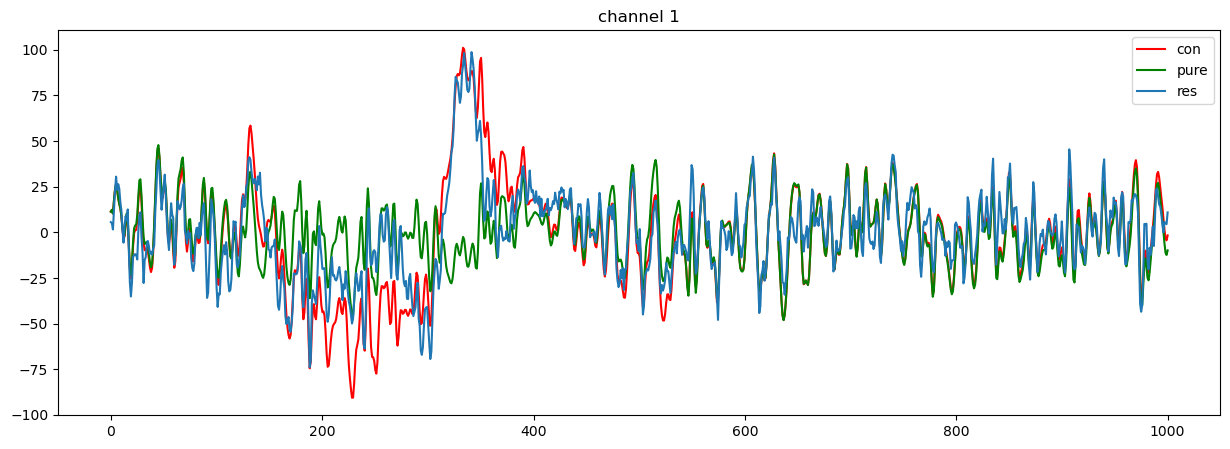

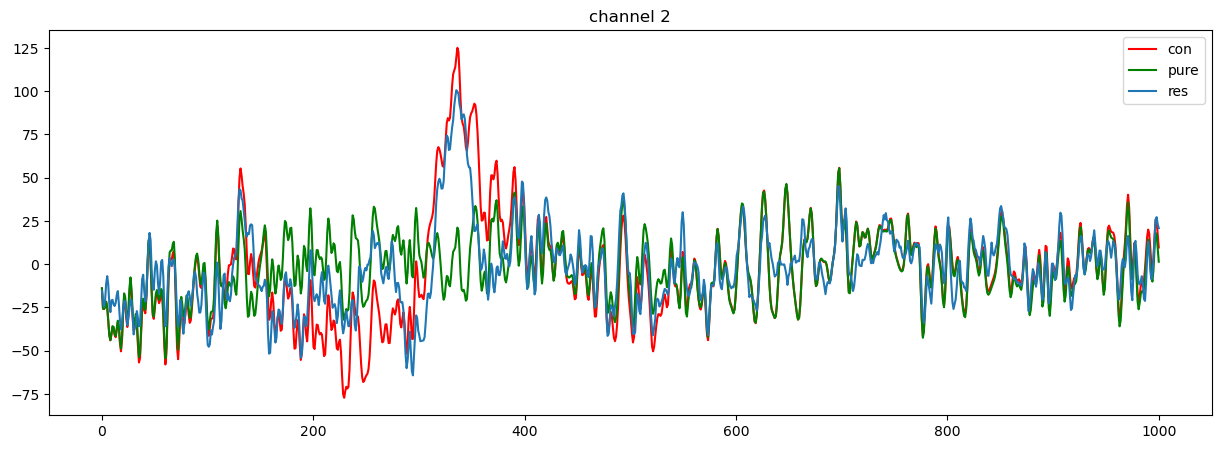

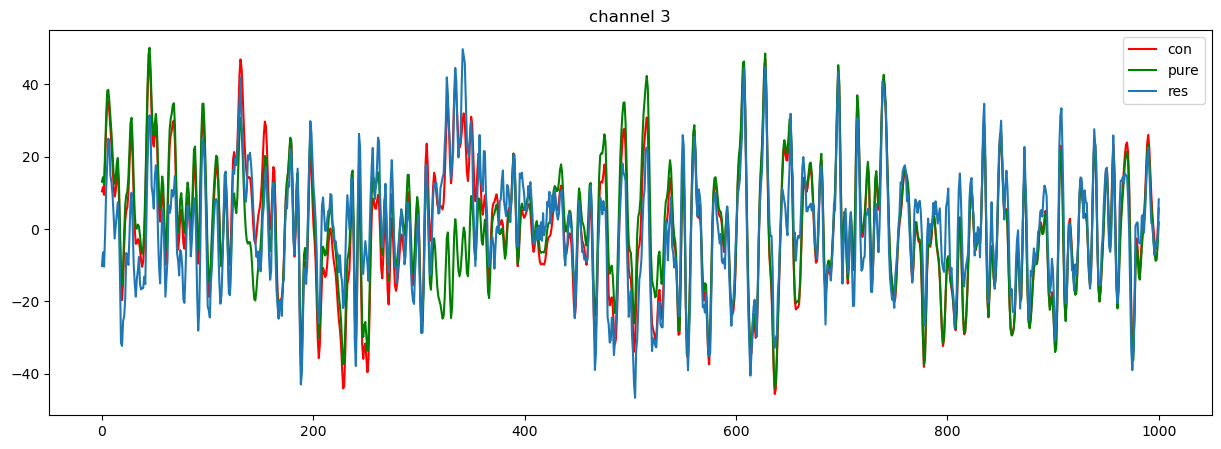

In [812]:
np.array(raw_without_artifacts.get_data())
idx_range = np.s_[0:1000]
for channel_idx in range(0, len(raw_without_artifacts.ch_names)):
    plt_data = raw_without_artifacts.get_data()[channel_idx][idx_range]
    
    origin = con_eeg[channel_idx][idx_range]
    pure = pure_eeg[channel_idx][idx_range]
    
    RRMSE = rrmse(raw_without_artifacts.get_data()[channel_idx] , pure_eeg[channel_idx])
    snr = SNR(con_eeg[channel_idx], con_eeg[channel_idx] - pure_eeg[channel_idx])
    print("Root Mean Square Error: ", RRMSE, "Signal to Noise Ratio: ", snr, '\n')
    
    plt.figure(figsize=(15, 5))
    plt.title('channel ' + str(channel_idx + 1))
    plt.plot(np.linspace(0, len(origin), len(origin)), origin, 'r', alpha=1)
    plt.plot(np.linspace(0, len(pure), len(pure)), pure, 'g', alpha=1)
    plt.plot(np.linspace(0, len(plt_data), len(plt_data)), plt_data)#results
    plt.legend(['con', 'pure', 'res'])

In [ ]:
print

In [43]:
print(index)

None
